<a href="https://colab.research.google.com/github/silvansam570-bit/DI_project/blob/main/Time_Series_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ======================================================
# CELL 1: Install Required Libraries & Import Modules
# ======================================================

!pip install numpy pandas matplotlib scikit-learn tensorflow shap -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Attention, Flatten

import shap


In [ ]:
# ======================================================
# CELL 2: Create Synthetic Benchmark Dataset
# Simulates energy consumption with environmental factors
# ======================================================

np.random.seed(42)

n = 5000
t = np.arange(n)

energy = 0.6*np.sin(0.01*t) + t*0.0004 + np.random.normal(0,0.05,n)
temp = 25 + 5*np.sin(0.02*t) + np.random.normal(0,0.5,n)
humidity = 55 + 8*np.sin(0.015*t) + np.random.normal(0,1,n)

data = pd.DataFrame({
    "energy": energy,
    "temperature": temp,
    "humidity": humidity
})

data.head()


,energy,temperature,humidity
0,0.024836,24.788120,54.321505
1,-0.000513,24.873286,54.814496
2,0.045184,24.302125,54.642583
3,0.095349,25.134775,55.470297
4,0.013886,25.765988,56.676891


In [ ]:
# ======================================================
# CELL 3: Create Lag Features & Rolling Statistics
# Improves model temporal understanding
# ======================================================

for lag in [1,2,3,24]:
    data[f'energy_lag_{lag}'] = data['energy'].shift(lag)

data['rolling_mean_24'] = data['energy'].rolling(24).mean()
data['rolling_std_24'] = data['energy'].rolling(24).std()

data.dropna(inplace=True)


In [ ]:
# ======================================================
# CELL 4: Normalize Data
# ======================================================

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled, columns=data.columns)

In [ ]:
# ======================================================
# CELL 5: Convert Series into Supervised Learning Windows
# ======================================================

window = 30

X,y = [],[]
values = scaled_df.values

for i in range(len(values)-window):
    X.append(values[i:i+window])
    y.append(values[i+window][0])

X = np.array(X)
y = np.array(y)

print("Shape:",X.shape)


Shape: (4946, 30, 9)


In [ ]:
# ======================================================
# CELL 6: Time-Series Split (No Random Shuffle)
# ======================================================

split = int(len(X)*0.8)

X_train,X_test = X[:split],X[split:]
y_train,y_test = y[:split],y[split:]


In [ ]:
# ======================================================
# CELL 7: Baseline Models
# Persistence + Linear Regression
# ======================================================

# Persistence baseline
baseline_pred = X_test[:,-1,0]

# Linear regression baseline
lr = LinearRegression()
lr.fit(X_train.reshape(len(X_train),-1),y_train)

lr_pred = lr.predict(X_test.reshape(len(X_test),-1))

print("Persistence MSE:",mean_squared_error(y_test,baseline_pred))
print("LinearReg MSE:",mean_squared_error(y_test,lr_pred))


Persistence MSE: 0.0005434829030292598
LinearReg MSE: 0.00031090990378855257


In [ ]:
# ======================================================
# CELL 8: Build Advanced Deep Learning Model
# Bidirectional LSTM + Attention Mechanism
# ======================================================

def build_model(units=64,dropout=0.2):

    inputs = Input(shape=(X.shape[1],X.shape[2]))

    x = Bidirectional(LSTM(units,return_sequences=True))(inputs)

    attn = Attention()([x,x])

    x = Flatten()(attn)
    x = Dropout(dropout)(x)

    outputs = Dense(1)(x)

    model = Model(inputs,outputs)

    model.compile(optimizer='adam',loss='mse')

    return model


In [ ]:
# ======================================================
# CELL 9: Simple Hyperparameter Tuning
# ======================================================

configs = [(32,0.1),(64,0.2),(128,0.2)]

best_model=None
best_loss=np.inf

for units,drop in configs:

    print("Testing:",units,drop)

    model=build_model(units,drop)

    history=model.fit(
        X_train,y_train,
        epochs=3,
        batch_size=64,
        verbose=0
    )

    loss=history.history['loss'][-1]

    if loss<best_loss:
        best_loss=loss
        best_model=model


Testing: 32 0.1
Testing: 64 0.2
Testing: 128 0.2


Epoch 1/12
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0014 - val_loss: 7.9034e-04
Epoch 2/12
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0012 - val_loss: 3.0967e-04
Epoch 3/12
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011 - val_loss: 5.5215e-04
Epoch 4/12
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010 - val_loss: 3.8607e-04
Epoch 5/12
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.8854e-04 - val_loss: 3.1561e-04
Epoch 6/12
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 9.3002e-04 - val_loss: 5.8601e-04
Epoch 7/12
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.3182e-04 - val_loss: 7.4703e-04
Epoch 8/12
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.3521e-04 - val_loss: 2.8612e-04
Epoch 9/12
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.1199e-04 - val_loss: 3.3905e-04
Epoch 10/12
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.7537e-04 - val_loss: 6.4300e-04
Epoch 11/12
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.1331e-04 - val_loss: 4.913

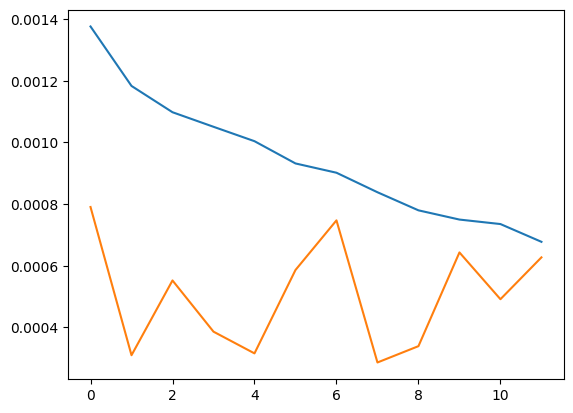

In [ ]:
# ======================================================
# CELL 10: Train Best Model Fully
# ======================================================

history = best_model.fit(
    X_train,y_train,
    epochs=12,
    batch_size=64,
    validation_split=0.1
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


In [ ]:
# ======================================================
# CELL 11: Model Evaluation
# ======================================================

pred = best_model.predict(X_test)

print("Deep Model MSE:",mean_squared_error(y_test,pred))
print("Deep Model MAE:",mean_absolute_error(y_test,pred))


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Deep Model MSE: 0.0006092310455096326
Deep Model MAE: 0.020429280481926954


  0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipython-input-705053295.py:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample_data)


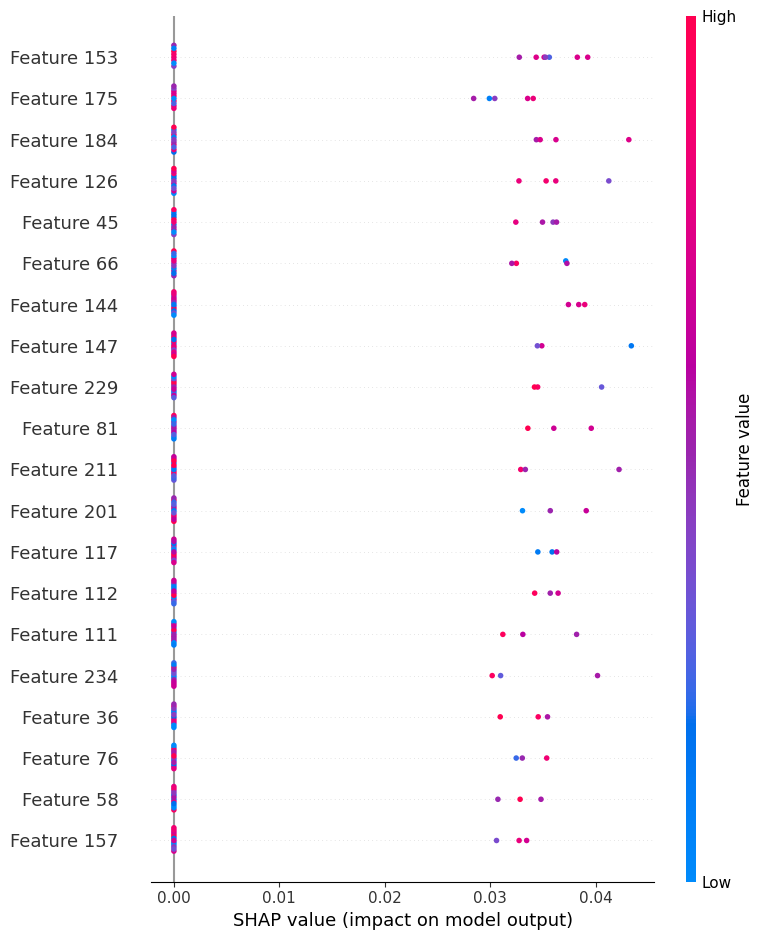

In [ ]:
# ======================================================
# CELL 12: SHAP Explainability (FINAL STABLE VERSION)
# KernelExplainer compatible with Attention + BiLSTM
# ======================================================

import shap
import numpy as np

# Flatten training and testing data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Prediction wrapper (VERY IMPORTANT: return 1D output)
def model_predict(data):
    data = np.array(data)
    data = data.reshape(data.shape[0], X.shape[1], X.shape[2])
    preds = best_model.predict(data, verbose=0)
    return preds.flatten()

# Small background sample (speed + stability)
background = X_train_flat[np.random.choice(X_train_flat.shape[0], 30, replace=False)]

# Create SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict, background)

# Compute SHAP values on small subset
sample_data = X_test_flat[:15]

shap_values = explainer.shap_values(sample_data)

# Plot summary
shap.summary_plot(shap_values, sample_data)


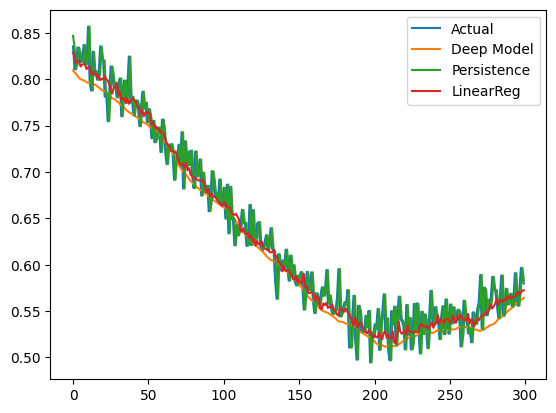

In [ ]:
# ======================================================
# CELL 13: Forecast Visualization
# ======================================================

plt.figure()

plt.plot(y_test[:300],label="Actual")
plt.plot(pred[:300],label="Deep Model")
plt.plot(baseline_pred[:300],label="Persistence")
plt.plot(lr_pred[:300],label="LinearReg")

plt.legend()
plt.show()